SNR Measurement for Field Strength Comparisons
===============================================

This notebook is a self contained workflow for analyzing relaxation and SNR measurements. 

Change plotting settings here for outer types of output (e.g. `inline`)

In [1]:
%matplotlib notebook

Functions for labeling and analyzing images

In [2]:
import os
import dicom

import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, moments
from skimage.morphology import closing, erosion, square
from scipy.signal import medfilt
from scipy.optimize import fmin

def display_dicom(dcm,colormap='gray',colorbar=True):
    fig, ax = plt.subplots(ncols=1, nrows=1)
    cax = ax.imshow(dcm.pixel_array,cmap=plt.get_cmap(colormap))

    if colorbar:
        fig.colorbar(cax)

def parse_dicom_tree(path):
    dcms = dict()
    for fn in os.listdir(path):
        ffn = os.path.join(path,fn)
        if os.path.isfile(ffn):
            try:
                ds = dicom.read_file(ffn)
                snum = ds.SeriesNumber
                if not snum in dcms:
                    dcms[snum] = list()
                dcms[snum].append(ds)
                
            except dicom.errors.InvalidDicomError:
                print("Skipping " + ffn + ", not a DICOM file")
    return dcms

def print_dicom_summary(dcms):
    series = sorted(dcms.keys())
    for s in series:
        print (str(dcms[s][0].SeriesNumber) + '\t' + str(len(dcms[s])) + '\t' + dcms[s][0].SeriesDescription)
        
def label_image(image, threshold_sensitivity=0.1,erosion_size=4):
    # apply threshold
    thresh = threshold_otsu(image)
    bw = closing(image > threshold_sensitivity*thresh, square(3))
    bw = erosion(bw, square(erosion_size))

    # remove artifacts connected to image border
    cleared = bw.copy()
    clear_border(cleared)

    # label image regions
    label_image = label(cleared)
    borders = np.logical_xor(bw, cleared)
    label_image[borders] = 0
    
    return label_image

def display_labels(label_image):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(label_image,cmap=plt.cm.gray)

    for l in range(1,np.max(label_image)+1):
        ml = (label_image == l)
        m = moments(ml.astype(np.double))
        c = m[0, 1] / m[0, 0], m[1, 0] / m[0, 0]
        ax.text(c[1], c[0],str(l),color='red')
        
def calc_flip_angle_map(dcm1,dcm2):
    if dcm1.FlipAngle > dcm2.FlipAngle:
        im_low = dcm2.pixel_array
        im_high = dcm1.pixel_array
        flip_angle_low = dcm2.FlipAngle
        flip_angle_high = dcm1.FlipAngle
    else:
        im_low = dcm1.pixel_array
        im_high = dcm2.pixel_array
        flip_angle_low = dcm1.FlipAngle
        flip_angle_high = dcm2.FlipAngle

    if flip_angle_high != 2*flip_angle_low:
        raise Exception('Low flip angle is not half of high flip angle')
    
    im_low = medfilt(im_low.astype(np.double),5)
    im_high = medfilt(im_high.astype(np.double),5)

    q = im_high/(2*(im_low+np.finfo(np.double).eps))
    q = np.clip(q,-1, 1);
    fa = np.arccos(q)*(180/np.pi);    
    
    #q = im_low/(im_high+np.finfo(np.double).eps)
    #q = np.clip(q,-1, 1);
    #fa = np.arcsin(q)*(180/np.pi);    

    fa = fa/flip_angle_low
    return fa

def get_label_mean(img,label_image,labels=[]):
    if not labels:
        labels = range(np.min(label_image),np.max(label_image)+1)
    
    means = list()
    for l in labels:
        m = (label_image == l).astype(np.double)
        s = np.sum(m*img)/np.sum(m)
        means.append(s)
        
    return means

def get_IR_data(dcms, label_image, labels=[]):
    if not labels:
        labels = range(np.min(label_image),np.max(label_image)+1)

    images = len(dcms)
    labs = len(labels)

    TIs = np.zeros((images,),dtype=np.double)
    signal = np.zeros((images,labs),dtype=np.double)

    for idx, im in enumerate(dcms):
        means = get_label_mean(im.pixel_array,label_image,labels=labels)
        signal[idx,:] = np.array(means)
        TIs[idx] = im.InversionTime
        
    idx = [i[0] for i in sorted(enumerate(TIs), key=lambda x:x[1])]  
    signal = signal[idx,:]
    TIs = TIs[idx]
    
    return TIs, signal

def fit_t1_mag_IR(TIs, IRSignal):
    #Doing 3 parameters fit
    # S = A - B exp(-TI./T1star)
    
    if len(IRSignal.shape) > 1:
        curves = IRSignal.shape[1]
    else:
        curves = 1
    
    fits = list()
    for c in range(0,curves):
        #First get a starting estimate
        s = IRSignal[:,c]
        ss = sorted(enumerate(abs(s)), key=lambda x: x[1])
        if ss[0][0] == 0: 
            T1star = np.min(TIs)/np.log(2);
        else:
            tmp = ss[0:2]
            if tmp[0][0] > tmp[1][0]:
                tmp = [tmp[1], tmp[0]]
            slope = (tmp[1][1] + tmp[0][1])/(TIs[tmp[1][0]]-TIs[tmp[0][0]])
            T1star = (tmp[0][1]/slope + TIs[tmp[0][0]])/np.log(2)
        

        #Next let's do the fit with scipy.optimize.fmin (simplex)
        Ainit = np.max(np.abs(s))
        x0 = [Ainit, 2*Ainit, T1star] 
        costfcn = lambda x: np.sum((np.abs(x[0]-x[1]*np.exp(-TIs/x[2]))-s)**2)
        x = fmin(costfcn,x0=x0,disp=False)
        fits.append(x)
        
    return fits

def get_SE_data(dcms, label_image, labels=[]):
    if not labels:
        labels = range(np.min(label_image),np.max(label_image)+1)

    images = len(dcms)
    labs = len(labels)

    TEs = np.zeros((images,),dtype=np.double)
    signal = np.zeros((images,labs),dtype=np.double)

    for idx, im in enumerate(dcms):
        means = get_label_mean(im.pixel_array,label_image,labels=labels)
        signal[idx,:] = np.array(means)
        TEs[idx] = im.EchoTime
        
    idx = [i[0] for i in sorted(enumerate(TEs), key=lambda x:x[1])]  
    signal = signal[idx,:]
    TEs = TEs[idx]
    
    return TEs, signal

def fit_t2_SE(TEs,signal):
    #Doing s parameters fit
    # S = A exp(-TE./T2)
    
    if len(IRSignal.shape) > 1:
        curves = IRSignal.shape[1]
    else:
        curves = 1
    
    fits = list()
    for c in range(0,curves):
        #First get a starting estimate
        s = signal[:,c]
        y = np.log(np.abs(s))
        x = TEs;
        b = np.sum((x - np.mean(x))*(y - np.mean(y)))/np.sum((x - np.mean(x))**2)
        a = np.mean(y) - b*np.mean(x)
        x0 = [np.exp(a), -1/b]

        costfcn = lambda x: np.sum((np.abs(x[0]*np.exp(-TEs/x[1]))-s)**2)
        x = fmin(costfcn,x0=x0,disp=False)
        fits.append(x)
    return fits

def imlist_to_pixel_array(imgs):
    img_size = imgs[0].pixel_array.shape
    img_array = np.zeros((len(imgs), img_size[0],img_size[1]))
    for idx, i in enumerate(imgs):
        img_array[idx,:,:] = i.pixel_array
    return img_array

Reading Images
===============

The analysis workflow starts with parsing all the dicom images in a given folder. The list below should give an overview of serries names and the number of images in each series.  

In [3]:
d = parse_dicom_tree('/home/hansenms/data/PANDA/NIH_AERA/B1Data')
print_dicom_summary(d)

Skipping /home/hansenms/data/PANDA/NIH_AERA/B1Data/RFSWDHistoryListNew.log, not a DICOM file
21	1	MiniFLASH_b1_map_60 ASTM__GT
22	1	MiniFLASH_b1_map_60 ASTM__GT_SNR_MAP
23	1	MiniFLASH_b1_map_60 ASTM__GT_Noise_SD_Plot
24	1	MiniFLASH_b1_map_120 ASTM__GT
25	1	MiniFLASH_b1_map_120 ASTM__GT_SNR_MAP
26	1	MiniFLASH_b1_map_120 ASTM__GT_Noise_SD_Plot


Classification of Image Series
===============================

Based on the list above, identify 

<IPython.core.display.Javascript object>


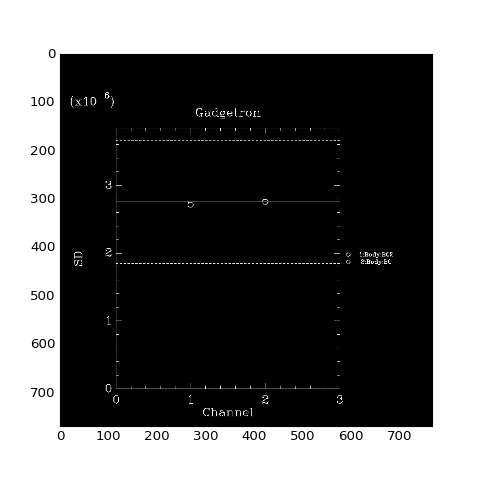

In [5]:
im = d[23][0]
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(im.pixel_array,cmap=plt.cm.gray)

In [13]:
fa_data_TRA = [22,25] #flip angle measurements
#fa_data_COR = [25,28] #flip angle measurements
#fa_data_SAG = [31,34] #flip angle measurements

fa_data = fa_data_TRA
line_no = 80
im_no = 1

<IPython.core.display.Javascript object>


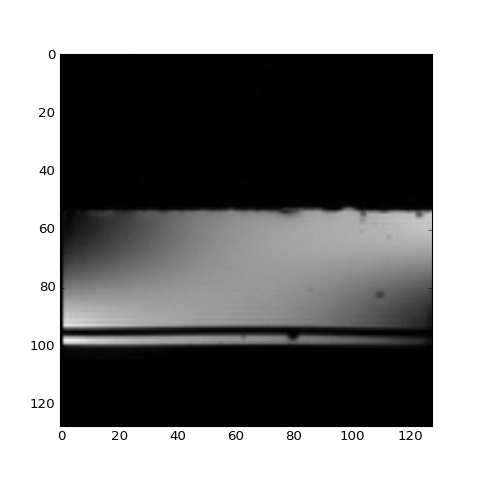

In [14]:
# Initial overview image
im = d[fa_data[im_no]][0]
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(im.pixel_array,cmap=plt.cm.gray)

<IPython.core.display.Javascript object>


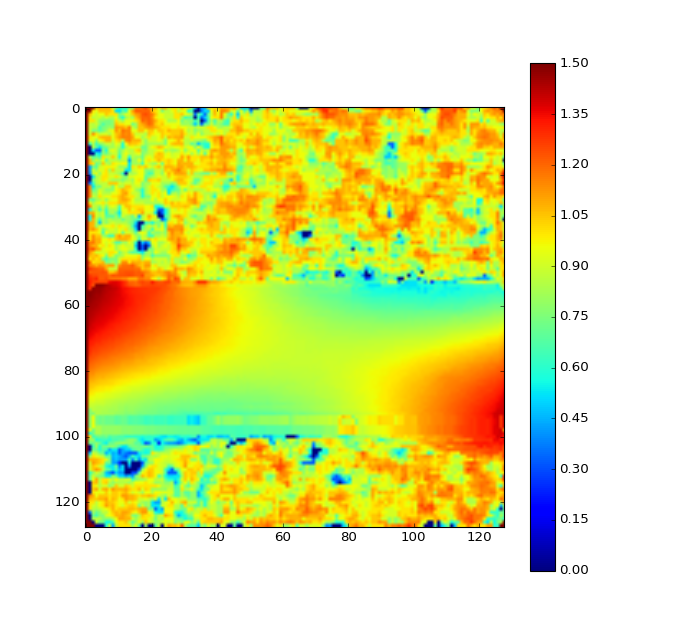

In [15]:
# Flip angle map
fa = calc_flip_angle_map(d[fa_data[0]][0],d[fa_data[1]][0])
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
img = ax.imshow(fa,cmap=plt.cm.jet)
fig.colorbar(img)

<IPython.core.display.Javascript object>


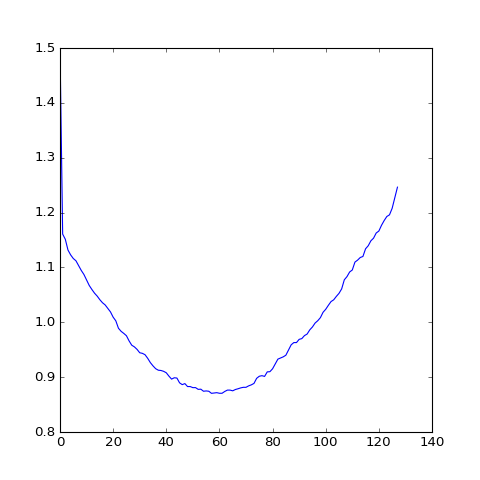

In [16]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.plot(fa[line_no,:])

In [11]:
snr_img = d[fa_data[im_no]][0]
snr_pixels = snr_img.pixel_array/10.0

<IPython.core.display.Javascript object>


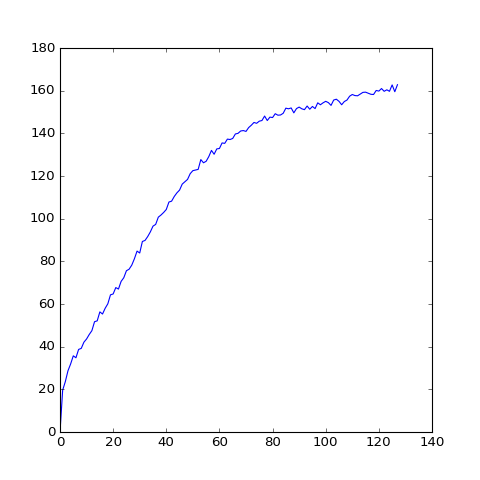

In [12]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.plot(snr_pixels[line_no,:])

In [10]:
flip_angle_ref = snr_img.FlipAngle*(2*np.pi/360)

<IPython.core.display.Javascript object>


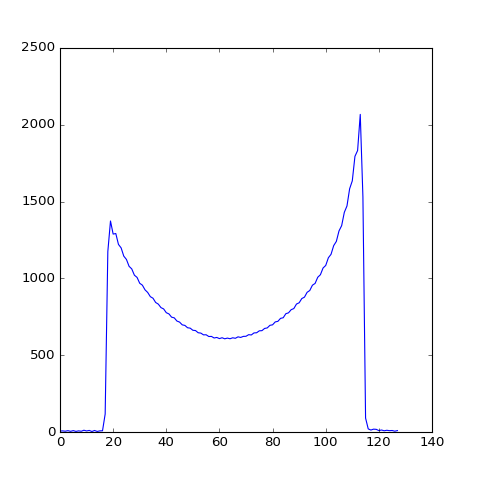

In [11]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.plot(snr_pixels[:,line_no]*(np.sin(flip_angle_ref)/np.sin(flip_angle_ref*fa[:,line_no])))
#ax.plot((np.sin(flip_angle_ref)/(np.sin(flip_angle_ref*fa[:,line_no]))))

In [12]:
np.sin(120*np.pi*2/360)/np.sin(1.15*120*np.pi*2/360)

1.2942546575428724

In [13]:
(1.5/0.55)/(595.0/95.0)

0.43544690603514125

In [14]:
470.0/92.0

5.108695652173913

In [15]:
1.5/0.55

2.727272727272727

In [16]:
(595.0/95.0)

6.2631578947368425